# Training a Simple GAN Model for Sentence Embeddings

In [1]:
latent_dim = 400

In [2]:
pip install tensorflow --upgrade

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import pandas as pd
import ast
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Activation
from matplotlib import pyplot as plt
from keras import backend
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


MAX_LENGTH = 768


class CustomDataset(Dataset):
    def __init__(self, embeddings):
        self.embeddings = embeddings

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx]


2024-04-14 02:20:00.512445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Preprocessing Data

In [4]:
#Limit number of rows for experimentation
df = pd.read_csv('../data/author_10000_cls.csv')
num_rows = len(df)
df = df[:num_rows]
df

,line_txt,author_labels,cls_token
0,"δαίμονι δʼ οἷος ἔησθα, τὸ ἐργάζεσθαι ἄμεινον,",0,tf.Tensor(\n[-4.03999180e-01 -4.44073975e-01 ...
1,"ὦ πέπον, οὐ μὲν γὰρ τοι Ἄρης θανάτοιο τελευτὴν",0,tf.Tensor(\n[ 3.42775553e-01 -4.48708475e-01 ...
2,"οἳ δή τοι τὰ μὲν ἄλλα θεοῖς ἐναλίγκιοι ἦσαν,",0,tf.Tensor(\n[-1.01096046e+00 -4.58268285e-01 -...
3,ἡνίοχοι βεβαῶτες ἐφίεσαν ὠκέας ἵππους,0,tf.Tensor(\n[-1.78759539e+00 6.87804341e-01 -...
4,ἡ δὲ κακὴ βουλὴ τῷ βουλεύσαντι κακίστη.,0,tf.Tensor(\n[-3.02882195e-01 -8.28379333e-01 ...
...,...,...,...
29995,Κρισαίων ἄλοχοι καλλίζωνοί τε θύγατρες,2,tf.Tensor(\n[-5.40540814e-01 8.87787491e-02 ...
29996,ἀμφὶς θυμὸν ἔχοντες. ὃ μὲν νημερτέα φωνὴν,2,tf.Tensor(\n[ 2.32343629e-01 -4.14683819e-02 ...
29997,ἐγκρύψαι μεμαώς· Λητοῦς δʼ ἐρικυδέος υἱὸν,2,tf.Tensor(\n[-1.3245641 -0.5897638 -0.377123...
29998,τόφρα οἱ ἐλπὶς ἔθελγε μέγαν νόον ἀχνυμένης περ·,2,tf.Tensor(\n[-5.21369755e-01 2.16294110e-01 ...


In [5]:
df['author_labels'].value_counts()

author_labels
0    10000
1    10000
2    10000
Name: count, dtype: int64

In [6]:
n_classes = df['author_labels'].nunique()

In [7]:
def turn_str_to_tensor(tensor_str):

    numbers = re.findall(r"[-+]?\d*\.\d+e[+-]?\d+|[-+]?\d*\.\d+|[-+]?\d+", tensor_str)
    tensor_values = list(map(float, numbers))
    tensor = tf.constant(tensor_values, dtype=tf.float32)[:-2]
    
    # Reshape the tensor to the desired shape if needed (e.g., 768 in this case)
    tensor = tf.reshape(tensor, [768])
    return torch.tensor(np.array(tensor), dtype=torch.float32)

In [8]:
# Load the text lines

embeddings = df['cls_token']

#Turn EagerTensors list to Normal Tensors list
embeddings_pytorch = [turn_str_to_tensor(e) for e in embeddings]

# Convert list of tensors to a single tensor
embeddings_tensor = torch.stack(embeddings_pytorch).squeeze(1)  # Adjust dimensions as needed

embeddings_tensor

tensor([[-0.4040, -0.4441,  0.7041,  ..., -0.4026, -0.2111,  0.6380],
        [ 0.3428, -0.4487,  0.4991,  ...,  0.0481,  0.6765, -0.2236],
        [-1.0110, -0.4583, -0.5113,  ...,  0.2417,  0.9868, -0.0115],
        ...,
        [-1.3246, -0.5898, -0.3771,  ..., -0.1805,  1.0422, -0.6755],
        [-0.5214,  0.2163,  0.6009,  ...,  1.2751, -0.5999, -0.1707],
        [-0.9567, -0.5634, -0.7843,  ...,  1.0162,  0.8442, -0.1959]])

In [9]:
embeddings_tensor.shape

torch.Size([30000, 768])

In [10]:
#Initialize Dataset
embeddings = embeddings_tensor 

# Instantiate the custom dataset
dataset = CustomDataset(embeddings)

# Training the SGAN Model

In [11]:
X = embeddings_tensor
y = df['author_labels'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=6)
print(X_test.shape)
print(y_test.shape)

torch.Size([7500, 768])
(7500,)


In [12]:
X_train

tensor([[ 0.3495, -0.1538,  0.3692,  ...,  1.0807, -0.7592, -1.1573],
        [-0.0646, -0.1576,  0.3196,  ...,  1.3880,  0.0664,  0.6178],
        [-0.7930, -0.3935,  0.9363,  ...,  1.0103, -0.4008,  0.3502],
        ...,
        [-0.4339,  0.5769,  0.0076,  ...,  1.1630,  1.2759,  1.4522],
        [-0.9528, -0.2041,  0.8846,  ...,  0.4398,  0.6778,  0.9783],
        [-0.9127,  0.2011,  0.3811,  ...,  0.3338,  0.1968, -1.0321]])

The next code block contains all the helper functions and the training script. The main functions to look at are the 
define_discriminator, define_generator, and define_gan functions. They contain the model architecture for the discriminator and generator functions.

In [13]:
lr = 3e-4
n_samples = 2000
n_epochs = 2
loss_var_threshold = 0.001

# define the standalone supervised and unsupervised discriminator models
def define_discriminator(units = 100, in_shape=(MAX_LENGTH,), n_classes=df['author_labels'].nunique(), activation = 'relu'):
    
  # Embedding input
  in_image = Input(shape=in_shape)

  # downsample
  fe = Dense(units=units, activation=activation)(in_image)
  fe = LeakyReLU(alpha=0.2)(fe)

  # downsample
  fe = Dense(units=units, activation=activation)(in_image)
  fe = LeakyReLU(alpha=0.2)(fe)
    
  # dropout
  fe = Dropout(0.2)(fe)

  # output layer nodes
  fe = Dense(n_classes)(fe)
    
  # supervised output
  c_out_layer = Activation('softmax')(fe)
    
  # define and compile supervised discriminator model
  c_model = Model(in_image, c_out_layer, name = "supervised-discriminator")
  c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr, beta_1=0.5), metrics=['accuracy'])
    
  # unsupervised output
  d_out_layer = Dense(units = n_classes + 1, activation = 'softmax')(fe)
    
  # define and compile unsupervised discriminator model
  d_model = Model(in_image, d_out_layer, name = 'discriminator-fake')
  d_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr, beta_1=0.5), metrics = ['accuracy'])
  d_model.trainable = True
  c_model.trainable = True
    
  return d_model, c_model

# define the standalone generator model
def define_generator(latent_dim, units = 200, n_outputs=MAX_LENGTH):
	model = Sequential(name = 'generator')
	model.add(Dense(units, activation='sigmoid', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(int(units/2), activation='sigmoid'))
	model.add(Dense(n_outputs, activation='tanh'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # Ensure the discriminator's parameters are not trainable in the combined model
    discriminator.trainable = False
    
    # Create a new input layer for the GAN (noise sample)
    gan_input = Input(shape=(latent_dim,))
    
    # Output of the generator
    generator_output = generator(gan_input)
    
    # Output of the discriminator (takes generator's output as input)
    gan_output = discriminator(generator_output)
    
    # Define the GAN model
    gan = Model(gan_input, gan_output, name = 'gan-model')
    
    # Compile the GAN model
    optimizer = Adam(learning_rate=lr)
    gan.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')
    
    return gan


# load the embeddings and classifications
def load_real_samples(X,y):
	print(X.shape, y.shape)
	return [X, y]

# select a supervised subset of the dataset, ensures classes are balanced
def select_supervised_samples(dataset, n_samples=n_samples, n_classes=df['author_labels'].nunique()):
    X, y = dataset
    n_per_class = int(n_samples / n_classes)
    X_samples = []
    y_samples = []

    
    for class_index in range(n_classes):
        
        # Find the indices of all samples belonging to the current class
        class_indices = np.where(y == class_index)[0]
        
        # Randomly choose n_per_class indices for this class
        selected_indices = np.random.choice(class_indices, n_per_class, replace=False)
        # Append the selected samples to the lists
        X_samples.append(X[selected_indices])
        y_samples.append(y[selected_indices])
    
    # Concatenate all selected samples
    X_samples = np.concatenate(X_samples, axis=0)
    y_samples = np.concatenate(y_samples, axis=0)
    return X_samples, y_samples

    
def generate_real_samples(dataset, n_samples = n_samples):
    features, labels = dataset
    # Generate random indices
    indices = np.random.choice(features.shape[0], n_samples, replace=False)
    # Select a random subset of features and labels using the indices
    X = features[indices]
    labels = labels[indices]
    return X, labels

def generate_real_samples_multiclass(dataset, n_samples = n_samples):
    features, labels = dataset
    # Generate random indices
    indices = np.random.choice(features.shape[0], n_samples, replace=False)
    # Select a random subset of features and labels using the indices
    X = features[indices]
    labels = labels[indices]
    # Generate class labels (assuming you want all ones for real samples)
    y = np.ones((n_samples, 1))
    return [X, labels], y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	z_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = z_input.reshape(n_samples, latent_dim)
	return z_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    
	# generate points in latent space
	z_input = generate_latent_points(latent_dim, n_samples)
    
	# predict outputs
	images = generator.predict(z_input)
	# create class labels
	y = np.ones((n_samples, 1)) * n_classes
	return images, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, dataset, acc_list, n_samples=100):
    
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    
	# evaluate the classifier model
	_, acc = d_model.evaluate(X, np.ones(len(X)) * df['author_labels'].nunique(), verbose=0)
	acc_list.append(acc)
	print('Classifier Accuracy With Fake Data: %.3f%%' % (acc * 100))

def train_multiclass_classification_model(c_model, n_epochs=n_epochs, n_batch=100):
    """
    Trains only c model since there are no fake samples associated with it
    """

    def plot_acc_history(history, title, xlabel = 'Epoch', ylabel = 'Accuracy'):
        plt.figure(figsize=(8, 4))
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(title)
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.savefig(f'{title}.png', dpi = 500, bbox_inches = 'tight')
        plt.show()

    def plot_loss_history(history, title, xlabel = 'Epoch', ylabel = 'Loss'):
        plt.figure(figsize=(8, 4))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss Progression')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.savefig(f'{title}.png', dpi = 500, bbox_inches = 'tight')
        plt.show()

     # select supervised dataset
    X_sup, y_sup = select_supervised_samples([X_train, y_train], len(X_train)/2)

    indices = np.arange(X_sup.shape[0])
    np.random.shuffle(indices)
    
    # Shuffle selected samples
    X_sup, y_sup = X_sup[indices], y_sup[indices]
    
    print(X_sup.shape, y_sup.shape)
    
    
    print('n_epochs=%d, batch_size=%d' % (n_epochs, n_batch))

    c_history = c_model.fit(X_sup, y_sup, epochs=n_epochs, batch_size=n_batch, validation_split=0.1)

    plot_acc_history(c_history, 'Accuracy of Multiclass Classification')
    plot_loss_history(c_history, 'Loss of Multiclass Classification')

    return c_model

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, acc_list, n_epochs = n_epochs, n_batch = 100):

    def performance_graph(acc = True, batch_per_epo = int(dataset[0].shape[0] / n_batch)):
        plt.figure(figsize=(8, 4))
        steps = [i for i in range(len(d_losses))]
        if acc:
            plt.title('Accuracy of the Model')
            plt.plot(steps, d_accs, label = 'Multiclass Discriminator with Fake Data')

        else:
            plt.plot(steps, d_losses, label = 'Multiclass Discriminator with Fake Data')
            plt.plot(steps, g_losses, label = 'GAN Model')
            plt.title('Losses of the Different Models')

        plt.legend()

        plt.xlabel('Epoch')
        if acc:
            plt.ylabel('Accuracy')
        else:
            plt.ylabel('Loss')

        plt.savefig(f'performance_graph_acc{int(acc)}.png', dpi = 500, bbox_inches = 'tight')
        plt.show()

    print(f'Latent dimensions: {latent_dim}\n-------------')
    print(f'Num epochs: {n_epochs}\n-------------')
    print(f'Num batches: {n_batch}\n-------------')
    
    # Initialize lists to track losses
    d_losses, d_accs, g_losses = [], [], []

    loss_variance_threshold = loss_var_threshold  # Set a threshold for the variance (for custom stopping)
    
    min_epochs = 5  # Set a minimum number of epochs to prevent stopping too early
    
    # select supervised dataset
    X_sup, y_sup = select_supervised_samples([X_train, y_train], len(X_train)/2)

    indices = np.arange(X_sup.shape[0])
    np.random.shuffle(indices)
    
    # Shuffle selected samples
    X_sup, y_sup = X_sup[indices], y_sup[indices]
    
    print(X_sup.shape, y_sup.shape)
    
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    
    print('n_epochs=%d, batch_size=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, bat_per_epo, n_steps))

    # manually enumerate epochs
    for i in range(n_steps):
        
        
        # update unsupervised discriminator (d) on real samples
        X_real, y_real = generate_real_samples(dataset, n_batch)
        d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)  # Capture loss and accuracy
        
        # update unsupervised discriminator (d) on fake samples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)  # Capture loss and accuracy

        
        # update generator (g)
        X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(X_gan, y_gan)

        print('>%d, d(loss on real and fake)[%.3f,%.3f], d(acc on real and fake)[%.3f,%.3f], g(loss)[%.3f]' % (i+1, d_loss1, d_loss2, d_acc1 * 100, d_acc2 * 100, g_loss))

    
        # evaluate the model performance every so often
        if (i+1) % (bat_per_epo) == 0:
            # At the end of each epoch in training loop:
            d_losses.append((d_loss1 + d_loss2) / 2)
            g_losses.append(g_loss)
            d_accs.append((d_acc1 + d_acc1) / 2)
        

    performance_graph(acc =  True)
    performance_graph(acc =  False)



In [14]:
def def_models(latent_dim):
    d_model, c_model = define_discriminator()
    g_model = define_generator(latent_dim, units = latent_dim)
    gan_model = define_gan(g_model, d_model)
    d_model.trainable = True
    c_model.trainable = True
    gan_model.trainable = True
    g_model.trainable = True
    return d_model, c_model, g_model, gan_model

def train_script(latent_dim, n_epochs, n_batch, train_dataset, acc_list=[], c = True):
    d_model, c_model, g_model, gan_model = def_models(latent_dim)

    if c:
        train_multiclass_classification_model(c_model, n_epochs = n_epochs, n_batch = n_batch)
        return c_model
    else:
        
        train(g_model, d_model, gan_model, train_dataset, latent_dim, acc_list, n_epochs=n_epochs, n_batch=n_batch)
        return c_model, d_model, g_model, gan_model


### Generating Predictions and Evaluating Model Performance

### Retraining the Best Models from Grid Search

Grid Search Results: 
* Best dimensions for Baseline Classifier Model: latent: 400, epoch: 10, batch: 500
* Best dimensions for the Discriminator Classifier Model: latent: 500, epoch: 10, batch: 1000


In order to standardize model architecture, we will use the hyperparameters that yielded the best discriminator model to construct the baseline model. Aligning the architectures and hyperparameters used to construct the baseline and discriminator model will allow appropriate performance comparisons. 

The following diagrams are our model architectures.

In [15]:
d_model, c_model, g_model, gan_model = def_models(400)
d_model.summary()

/Users/thossain64/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Users/thossain64/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "discriminator-fake"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        76,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           303 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,219 (301.64 KB)

 Trainable params: 77,219 (301.64 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
c_model.summary()

Model: "supervised-discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        76,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           303 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,203 (301.57 KB)

 Trainable params: 77,203 (301.57 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
gan_model.summary()

Model: "gan-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator (Sequential)          │ (None, 768)            │       394,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator-fake (Functional) │ (None, 4)              │        77,219 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 472,187 (1.80 MB)

 Trainable params: 472,187 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
g_model.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 400)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 768)            │       154,368 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,968 (1.51 MB)

 Trainable params: 394,968 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

Below is the script to train our models.

torch.Size([22500, 768]) (22500,)
(11250, 768) (11250,)
n_epochs=10, batch_size=1000
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3354 - loss: 1.3600 - val_accuracy: 0.3938 - val_loss: 1.1302
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3861 - loss: 1.1875 - val_accuracy: 0.4116 - val_loss: 1.0975
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4262 - loss: 1.1071 - val_accuracy: 0.4427 - val_loss: 1.0705
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4657 - loss: 1.0532 - val_accuracy: 0.4498 - val_loss: 1.0394
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4837 - loss: 1.0205 - val_accuracy: 0.4569 - val_loss: 1.0369
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5027 - loss: 0.9946 - val_accuracy: 0.4942 - val_loss: 1.0057
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5192 - loss: 0.9743 - val_accuracy: 0.5120 - val_loss: 0.9917
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━

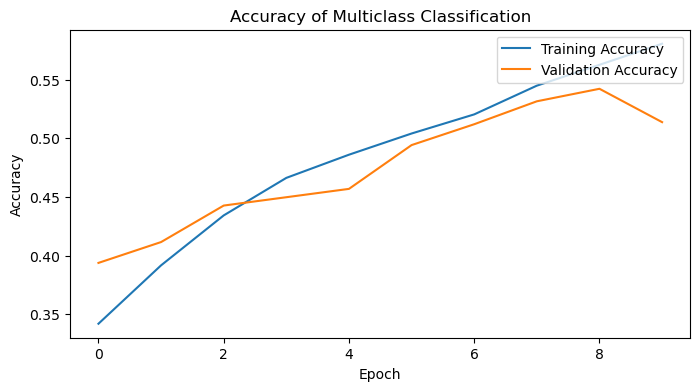

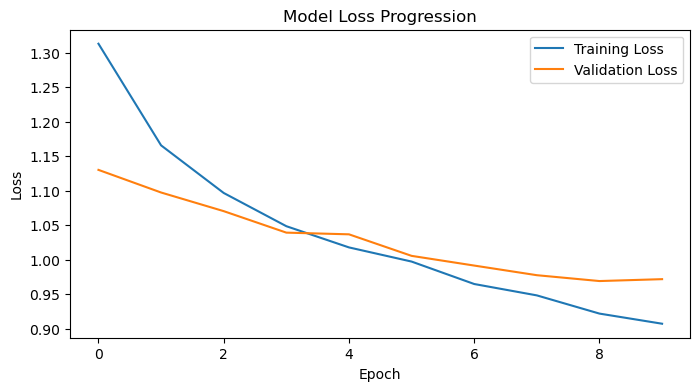

torch.Size([22500, 768]) (22500,)
(11250, 768) (11250,)
n_epochs=10, batch_size=1000
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3355 - loss: 1.3653 - val_accuracy: 0.3769 - val_loss: 1.1268
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3829 - loss: 1.1767 - val_accuracy: 0.4222 - val_loss: 1.0718
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4339 - loss: 1.0977 - val_accuracy: 0.4427 - val_loss: 1.0486
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4640 - loss: 1.0457 - val_accuracy: 0.4747 - val_loss: 1.0323
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4932 - loss: 1.0109 - val_accuracy: 0.4907 - val_loss: 1.0145
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5122 - loss: 0.9865 - val_accuracy: 0.5022 - val_loss: 0.9989
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5382 - loss: 0.9597 - val_accuracy: 0.5200 - val_loss: 0.9839
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━

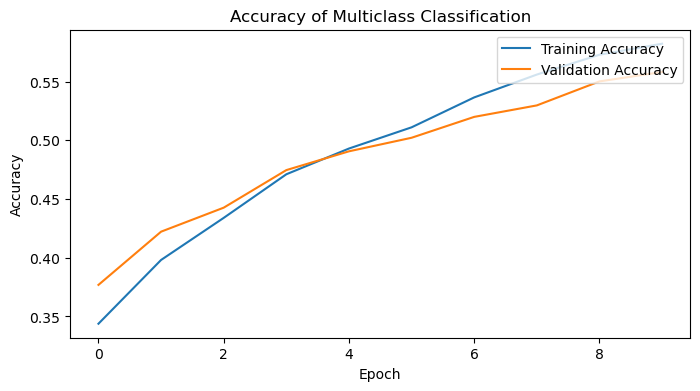

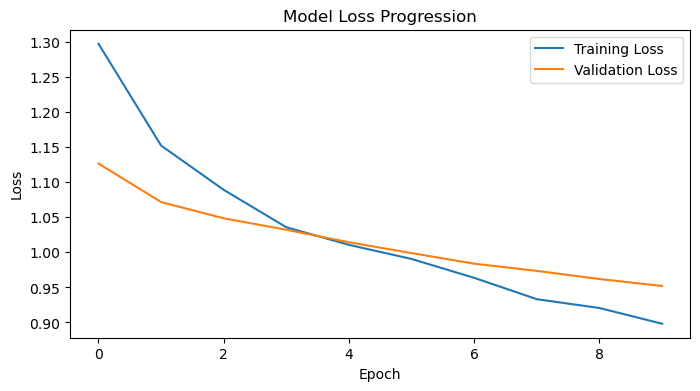

Latent dimensions: 500
-------------
Num epochs: 10
-------------
Num batches: 1000
-------------
(11250, 768) (11250,)
n_epochs=10, batch_size=1000, b/e=22, steps=220
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
>1, d(loss on real and fake)[1.600,1.572], d(acc on real and fake)[29.600,18.100], g(loss)[1.548]
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
>2, d(loss on real and fake)[1.552,1.428], d(acc on real and fake)[22.600,17.050], g(loss)[1.154]
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
>3, d(loss on real and fake)[1.431,1.376], d(acc on real and fake)[20.820,17.350], g(loss)[0.953]
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
>4, d(loss on real and fake)[1.382,1.358], d(acc on real and fake)[19.957,17.462], g(loss)[0.827]
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
>5, d(loss on real and fake)[1.364,1.354], d(acc on real and fake)[19.444,17.500], g(loss)[0.741]
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
>6, d(loss on real and fake)[1.358,1.357], d(acc on real and fake)[19.236,17.633], g(loss)[0.677]
32/32

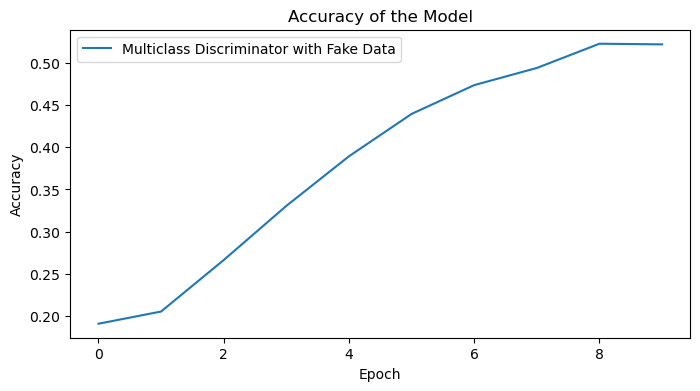

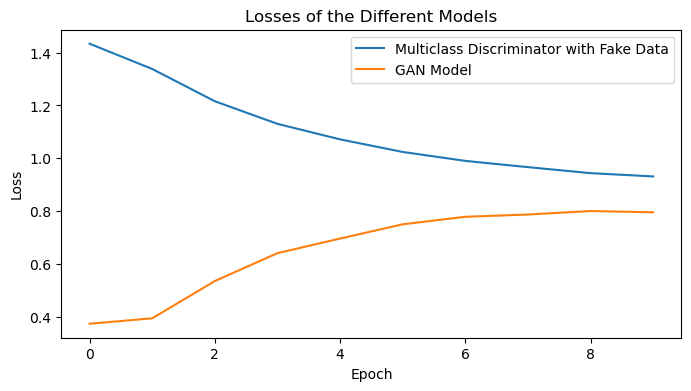

In [19]:
tf.keras.backend.clear_session()
latent_dim = 500
epochs = 10
batch_size = 1000
dataset = load_real_samples(X_train,y_train)

best_c_model = train_script(latent_dim=latent_dim, n_epochs=epochs, n_batch=batch_size, train_dataset=dataset, c = True)

#to get the best discriminator model trained with fake data
latent_dim = 500
epochs = 10
batch_size = 1000
dataset = load_real_samples(X_train,y_train)

best_c_model = train_script(latent_dim=latent_dim, n_epochs=epochs, n_batch=batch_size, train_dataset=dataset, c = True)

_, best_d_model, best_g_model, best_gan = train_script(latent_dim=latent_dim, n_epochs=epochs, n_batch=batch_size, train_dataset=dataset, c = False)

Generating Fake Data for Model Evaluation

In [20]:
## Creating Fake Data

n_classes = 3

# Augmenting Test Data
fake_test_tokens, fake_test_labels = generate_fake_samples(best_g_model, latent_dim=latent_dim, n_samples=int(X_test.shape[0] / n_classes))

X_test_with_fakes = np.concatenate((X_test, fake_test_tokens), axis = 0)
y_test_with_fakes = np.concatenate((y_test, fake_test_labels.flatten()), axis = 0)

indices = tf.range(start=0, limit=tf.shape(X_test_with_fakes)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

X_test_with_fakes = tf.gather(X_test_with_fakes, shuffled_indices)
y_test_with_fakes = tf.gather(y_test_with_fakes, shuffled_indices)


#Augmenting Train Data
fake_train_tokens, fake_train_labels = generate_fake_samples(best_g_model, latent_dim=latent_dim, n_samples=int(X_train.shape[0] / n_classes))

X_train_with_fakes = np.concatenate((X_train, fake_train_tokens), axis=0)
y_train_with_fakes = np.concatenate((y_train, fake_train_labels.flatten()), axis=0)

indices = tf.range(start=0, limit=tf.shape(X_train_with_fakes)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

X_train_with_fakes = tf.gather(X_train_with_fakes, shuffled_indices)
y_train_with_fakes = tf.gather(y_train_with_fakes, shuffled_indices)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Generate Predictions from the Discriminator Classifier

In [21]:
# Test Set Predictions 
d_test_predictions = best_d_model.predict(X_test_with_fakes)
d_test_predicted_labels = d_test_predictions.argmax(axis=1)
d_test_loss, d_test_accuracy = best_d_model.evaluate(X_test_with_fakes, y_test_with_fakes)

test_discriminator_classification_report = classification_report(y_test_with_fakes, d_test_predicted_labels, target_names=['Hesiod', 'Homer', 'Homeric Hymns', 'Generated CLS'])

# Train Set Predictions
d_train_preds = best_d_model.predict(X_train_with_fakes) 
d_train_predicted_labels = d_train_preds.argmax(axis=1)
d_train_loss, d_train_acc = best_d_model.evaluate(X_train_with_fakes, y_train_with_fakes) # Fixed: Use evaluate method correctly

train_discriminator_classification_report = classification_report(y_train_with_fakes, d_train_predicted_labels, target_names=['Hesiod', 'Homer', 'Homeric Hymns', 'Generated CLS'])


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4353 - loss: 0.8858
 40/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  

/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4639 - loss: 0.8495


/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Generate Predictions from the Baseline Classifier

In [22]:
#Test Set Predictions
c_test_predictions = best_c_model.predict(X_test)
c_test_predicted_labels = c_test_predictions.argmax(axis=1)
c_test_loss, c_test_accuracy = best_c_model.evaluate(X_test, y_test)

test_baseline_classification_report = classification_report(y_test, c_test_predicted_labels, target_names=['Hesiod', 'Homer', 'Homeric Hymns'])

# Train Set Predictions
c_train_predictions = best_c_model.predict(X_train)
c_train_predicted_labels = c_train_predictions.argmax(axis=1)
c_train_loss, c_train_accuracy = best_c_model.evaluate(X_train, y_train)

train_baseline_classification_report = classification_report(y_train, c_train_predicted_labels, target_names=['Hesiod', 'Homer', 'Homeric Hymns'])

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5473 - loss: 0.9511
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5917 - loss: 0.9125


In [23]:
print("Discriminator Testing Set Performance: 10k Balanced Dataset")
print(test_discriminator_classification_report)
print("")
print("discriminator test loss: ", d_test_loss)
print("discriminator test accuracy: ", d_test_accuracy)

Discriminator Testing Set Performance: 10k Balanced Dataset
               precision    recall  f1-score   support

       Hesiod       0.62      0.58      0.60      2481
        Homer       0.30      0.67      0.42      2503
Homeric Hymns       0.55      0.48      0.51      2516
Generated CLS       0.00      0.00      0.00      2500

     accuracy                           0.43     10000
    macro avg       0.37      0.43      0.38     10000
 weighted avg       0.37      0.43      0.38     10000


discriminator test loss:  0.8866323828697205
discriminator test accuracy:  0.4318999946117401


In [24]:
print("Discriminator Training Set Performance: 10k Balanced Dataset")
print(train_discriminator_classification_report)
print("")
print("discriminator train loss: ", d_train_loss)
print("discriminator train accuracy: ", d_train_acc)

Discriminator Training Set Performance: 10k Balanced Dataset
               precision    recall  f1-score   support

       Hesiod       0.69      0.64      0.66      7519
        Homer       0.32      0.70      0.44      7497
Homeric Hymns       0.59      0.52      0.55      7484
Generated CLS       0.00      0.00      0.00      7500

     accuracy                           0.47     30000
    macro avg       0.40      0.47      0.41     30000
 weighted avg       0.40      0.47      0.41     30000


discriminator train loss:  0.8500056266784668
discriminator train accuracy:  0.4650999903678894


In [25]:
print("Baseline Testing Set Performance: 10k Balanced Dataset")
print(test_baseline_classification_report)
print("")
print("baseline test loss: ", c_test_loss)
print("baseline test accuracy: ", c_test_accuracy)

Baseline Testing Set Performance: 10k Balanced Dataset
               precision    recall  f1-score   support

       Hesiod       0.57      0.57      0.57      2481
        Homer       0.53      0.59      0.56      2503
Homeric Hymns       0.56      0.50      0.53      2516

     accuracy                           0.55      7500
    macro avg       0.55      0.55      0.55      7500
 weighted avg       0.55      0.55      0.55      7500


baseline test loss:  0.9496978521347046
baseline test accuracy:  0.5537333488464355


In [26]:
print("Baseline Training Set Performance: 10k Balanced Dataset")
print(train_baseline_classification_report)
print("")
print("baseline train loss: ", c_train_loss)
print("baseline train accuracy: ", c_train_accuracy)

Baseline Training Set Performance: 10k Balanced Dataset
               precision    recall  f1-score   support

       Hesiod       0.62      0.62      0.62      7519
        Homer       0.57      0.62      0.59      7497
Homeric Hymns       0.60      0.54      0.57      7484

     accuracy                           0.59     22500
    macro avg       0.59      0.59      0.59     22500
 weighted avg       0.59      0.59      0.59     22500


baseline train loss:  0.9069923758506775
baseline train accuracy:  0.5929333567619324


Data Export for Further Analysis 

In [27]:
## Baseline Data Export 

baseline_test_predictions = pd.DataFrame({"baseline_test_labels": y_test, 
                                          "baseline_test_preds": c_test_predicted_labels})

baseline_train_predictions = pd.DataFrame({"baseline_train_labels": y_train, 
                                          "baseline_train_preds": c_train_predicted_labels})

baseline_train_predictions.to_csv("10k_baseline_train_predictions", index=True)
baseline_test_predictions.to_csv("10k_baseline_test_predictions", index=True)

X_test_numpy = X_test.numpy()
X_train_numpy = X_train.numpy()

# Convert numpy array to DataFrame
X_test_df = pd.DataFrame(X_test_numpy)
X_train_df = pd.DataFrame(X_train_numpy)

# Save the DataFrame to a CSV file
X_test_df.to_csv('10k_baseline_X_test.csv', index=True)
X_train_df.to_csv('10k_baseline_X_train.csv', index=True)

In [28]:
## Discriminator Data Export 

discrim_test_predictions = pd.DataFrame({"discrim_test_labels": y_test_with_fakes, 
                                         "discrim_test_preds": d_test_predicted_labels})

discrim_train_predictions = pd.DataFrame({"discrim_train_labels": y_train_with_fakes, 
                                          "discrim_train_preds": d_train_predicted_labels})

discrim_test_predictions.to_csv("10k_discrim_test_predictions", index=True)
discrim_train_predictions.to_csv("10k_discrim_train_predictions", index=True)

discrim_X_test_numpy = X_test_with_fakes.numpy()
discrim_X_train_numpy = X_train_with_fakes.numpy()

discrim_X_test_df = pd.DataFrame(discrim_X_test_numpy)
discrim_X_train_df = pd.DataFrame(discrim_X_train_numpy)

discrim_X_test_df.to_csv('10k_discrim_X_test.csv', index=True)
discrim_X_train_df.to_csv('10k_discrim_X_train.csv', index=True)